# **MIDAS IIITD - Task 2 Part 3**

#### **Introduction**

For task three, a new dataset is used to retrain a pretrained model, utilising only 0-9 training samples. Furthermore, this model is compared to new uninitialised model to compare performance on the MNIST dataset.

*   Contains 10 classes.
*   This includes handwritten digits 0-9.

ON FURTHER QUALITATIVE ANALYSIS, IT IS SEEN THAT **THE IMAGES IN THESE DATASETS ARE INCORRECTLY LABELLED.** Yet, the training and testing was done. **As expected, very low accuracy was found on both the models**.


This notebook only contains part three of the task. Other parts are in subsequent notebooks.

#### **Preprocessing**

1.   All images of the MNIST dataset are of shape (28,28,1) by default.
2.   There is no data imbalance.
3.   The new dataset (mnistTask) has images are of shape (28,28,1) by default. 

Following steps are taken for preprocessing.

1. Resize both to 128 * 128 in order to use pretrained model
2. Normalize image between 0-1 by dividing by 255.

#### **Model and Training Details**

Two models are used as directed by the task:
1. Pretrained model on previous dataset.
2. Same network but randomly initialized.

**Pretrained Model**
Model checkpoints are loaded for the model trained in Part 2 of this task, and the same is retrained on this new data.
The final model is tested on MNIST test split.

**Random Initialised Network**
This model needs to be randomly initialised. On further study, it was seen that Keras by default uses **Glorot Initializer** (https://keras.io/api/layers/initializers/#glorotnormal-class).
For this implementation, instead of this, the **Random Normal Distribution** (https://keras.io/api/layers/initializers/#randomuniform-class) was chosen to initialize the weights for the network.

Categorical Cross Entropy is used as the loss function and Adam optimizer is used. Furthermore, ModelCheckpoints are added to :

  *   Save only the best model.
  *   Stop learning if the loss stagnates.
  *   Change learning rate of the model on the fly

# **Libraries**

In [1]:
'''
Libraries required to run the code.
'''

import numpy as np
import idx2numpy
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import random
import os
import seaborn as sns
from collections import Counter
import pickle
import tensorflow as tf
import keras
from  matplotlib import pyplot as plt
from PIL import Image, ImageOps
import gc
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import colors
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_curve, confusion_matrix
from keras.models import Sequential
from keras import optimizers
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Reshape, LSTM, BatchNormalization
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
from keras.constraints import maxnorm

# **Data Loading And Preprocessing**

#### **Loading New Data For Part 3**

In [23]:
# Data stores the Numpy Array while Category is the class.

data = []
category = []

'''
Helper Function to:
1. Load all Images as Numpy Arrays.
'''

'''
Preprocessing:
1. Convert 3D image to 1D image to reduce computations.
2. Normalize between 0 and 1.
3. Keep data type as Float32.
4. Resize using pillow image library. Resize to (128,128).
'''

img_folder = 'mnistTask'

def load_data(img_folder):

    for dir1 in tqdm(os.listdir(img_folder)):
        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path= os.path.join(img_folder, dir1,  file)
            pilload = Image.open(image_path)
            pilload = pilload.resize((128,128))
            image= np.array(pilload)
            image = image.astype('float32')
            image /= 255  
            data.append(image)
            category.append(dir1)
            pilload.close()

In [24]:
'''
Loading Dataset using function.
'''

load_data(img_folder)

'''
Create target dictionary
'''

target_dict = {k: v for v, k in enumerate(np.unique(category))}
target_val=  [target_dict[category[i]] for i in range(len(category))]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.47s/it]


#### Loading the MNIST dataset for testing

In [25]:
'''
Defining idx3 file paths
'''

test_images_path = 'MNIST/t10k-images.idx3-ubyte'
test_labels_path = 'MNIST/t10k-labels.idx1-ubyte'

test_data = idx2numpy.convert_from_file(test_images_path)
test_labels = idx2numpy.convert_from_file(test_labels_path)

In [26]:
'''
Deining new function and method to resize all MNIST images to (28,28) and apply preprocessing methods
similar to those used for previous data.
'''
# New data initialisation
mnist_test = []
mnist_test_labels = []

'''
Preprocessing:
1. Reload all images.
2. Normalize between 0 and 1.
3. Keep data type as Float32.
4. Resize using pillow image library. Resize to (128,128) to improve speed.
'''

def load_test_data(old_data, labels):

    for i in tqdm(range(0, len(old_data))):
        old = old_data[i]
        lab = labels[i]
        pilload = Image.fromarray(old.astype('uint8'))
        pilload = pilload.resize((128,128))
        image= np.array(pilload)
        image = image.astype('float32')
        image /= 255  
        mnist_test.append(image)
        mnist_test_labels.append(lab)
        pilload.close()


load_test_data(test_data, test_labels)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3873.98it/s]


In [27]:
'''
Checking shape of previous data and mnist data
'''

print(mnist_test[0].shape)
print(data[0].shape)

# All are same

(128, 128)
(128, 128)


#### Loading Previous (Part 1) Data for Analysis

In [28]:
# Data stores the Numpy Array while Category is the class.

data1 = []
category1 = []

'''
Helper Function to:
1. Load all Images as Numpy Arrays.
2. Only 0-9 selected
'''

'''
Preprocessing:
1. Convert 3D image to 1D image to reduce computations.
2. Normalize between 0 and 1.
3. Keep data type as Float32.
4. Resize using pillow image library. Resize to (128,128) to improve speed.
'''

img_folder = 'train'

def load_data1(img_folder):

    for dir1 in tqdm(os.listdir(img_folder)):
        
        # Select only 0-9
        dig = int(dir1[-3:])
        if (dig > 10):
            continue

        for file in os.listdir(os.path.join(img_folder, dir1)):
            image_path= os.path.join(img_folder, dir1,  file)
            pilload = Image.open(image_path).convert('L')
            pilload = pilload.resize((128,128))
            image= np.array(pilload)
            image = image.astype('float32')
            image /= 255  
            data1.append(image)
            category1.append(dir1)
            pilload.close()
            
'''
Loading Dataset using function.
'''

load_data1(img_folder)

'''
Create target dictionary
'''

target_dict1 = {k: v for v, k in enumerate(np.unique(category1))}
target_val1 =  [target_dict1[category1[i]] for i in range(len(category1))]

100%|██████████████████████████████████████████████████████████████████████████████████| 62/62 [00:05<00:00, 11.24it/s]


## Qualitative differences between dataset

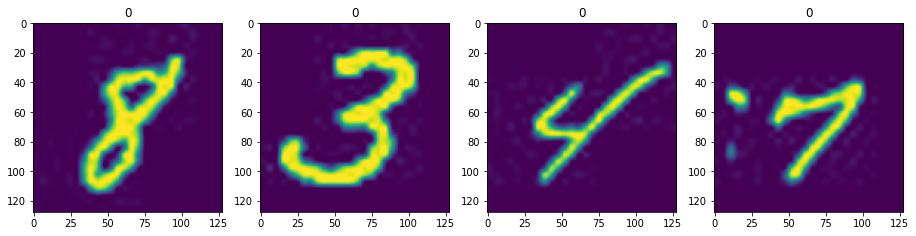

In [29]:
'''
Checking Labels of New Dataset
'''

# Part 3 Dataset


plt.figure(figsize=(40,20))
j = 0

for i in range(1,100,30):
    image = data[i]
    cat = category[i]
    ax=plt.subplot(1,10,j+1)
    j = j + 1
    plt.imshow(image)
    plt.title(cat)

###### We see below that the labels are '0' for digits 8,3,4 and 7. On studying the data it was seen that all images are incorrectly labelled.

This conclusion was reached after multiple tests hat gave low accuracy, even when the images are close to MNIST.
Training was done, but good results are not expected

Text(0.5, 1.0, 'TASK 3 DATASET')

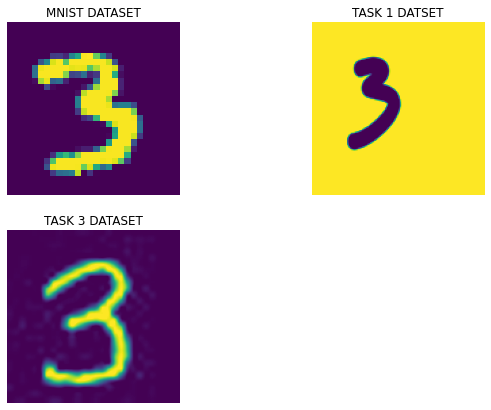

In [30]:
'''
To observe qualitative difference in all three dataset:
1. MNIST
2. Part 1 Data
3. Part 3 Data.

First we load original images without rescaling.
'''

fig = plt.figure(figsize=(10, 7))
rows = 2
columns = 2

#MNIST
img_mnist = test_data[500]
lab_mnist = test_labels[500]
pilload_mnist = Image.fromarray(img_mnist.astype('uint8'))

#Part 1
img_p1 = data1[120]
lab_p1 = category1[120]
pilload_p1 = np.array(Image.fromarray(img_p1)).astype('float32')

#Part 3
img_p2 = data[700]
lab_p2 = category[700]
pilload_p2 = np.array(Image.fromarray(img_p2)).astype('float32')

fig.add_subplot(rows, columns, 1)
plt.imshow(pilload_mnist)
plt.axis('off')
plt.title('MNIST DATASET')
  
fig.add_subplot(rows, columns, 2)
plt.imshow(pilload_p1)
plt.axis('off')
plt.title('TASK 1 DATSET')
  
fig.add_subplot(rows, columns, 3)
plt.imshow(pilload_p2)
plt.axis('off')
plt.title('TASK 3 DATASET')

#### Major Differences

1. All MNIST images are very small -> 28 * 28 in dimensions.
2. Task 1 imagesare very refined and large -> 900 * 1200 in dimensions. In addition to that, they are in RGB channel.
3. Task 3 dataset is closer to MNIST in respect of size. It is also one channeled and is 28 * 28
4. Furthermore, qualitatively, the new dataset has more data points.

#### Inference

1. While the MNIST dataset has images of the lowest quality, Task 1 dataset has very high quality images.
2. A model pretrained on only the task 1 dataset would need more time to converge to better adapt to the pixelation of MNIST.
3. On the other hand, task 3 dataset has pixelation similar to MNIST and is better suited for a pretrained model on MNIST dataset.
4. All this though, is irrelavant since the data is **incorrectly labelled.**

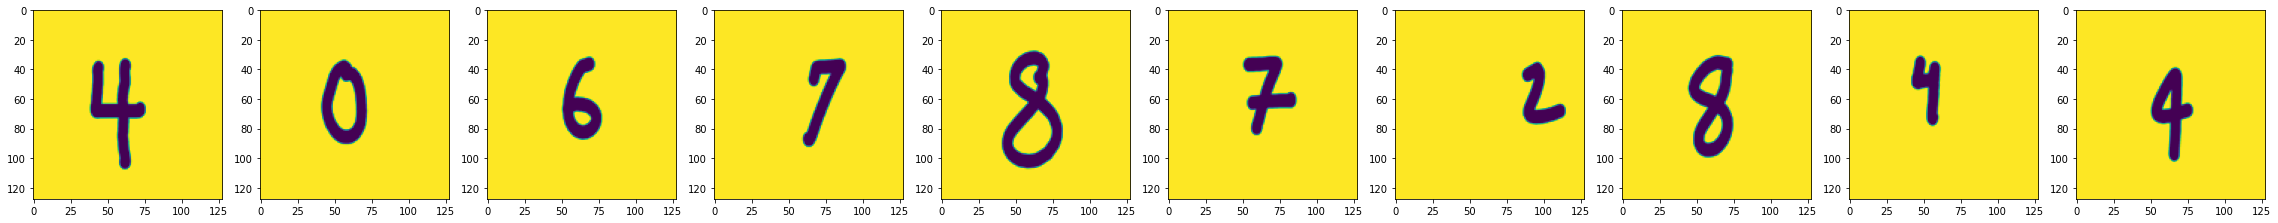

In [31]:
'''
Loading Multiple Samples
'''

# Part 1 Dataset


plt.figure(figsize=(40,20))

for i in range(10):
    image = random.choice(data1)
    ax=plt.subplot(1,10,i+1)
    plt.imshow(image)

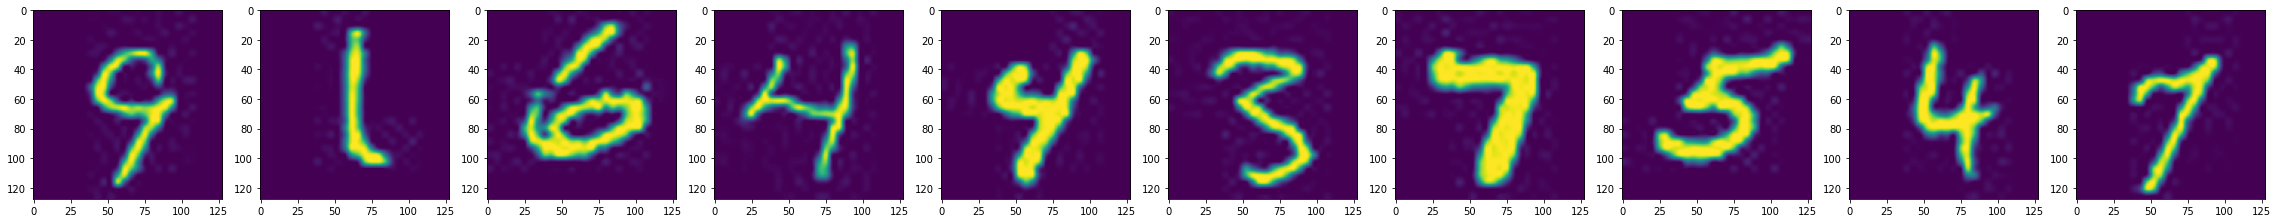

In [32]:
'''
Loading Multiple Samples
'''

# Part 3 Dataset


plt.figure(figsize=(40,20))

for i in range(10):
    image = random.choice(data)
    ax=plt.subplot(1,10,i+1)
    plt.imshow(image)

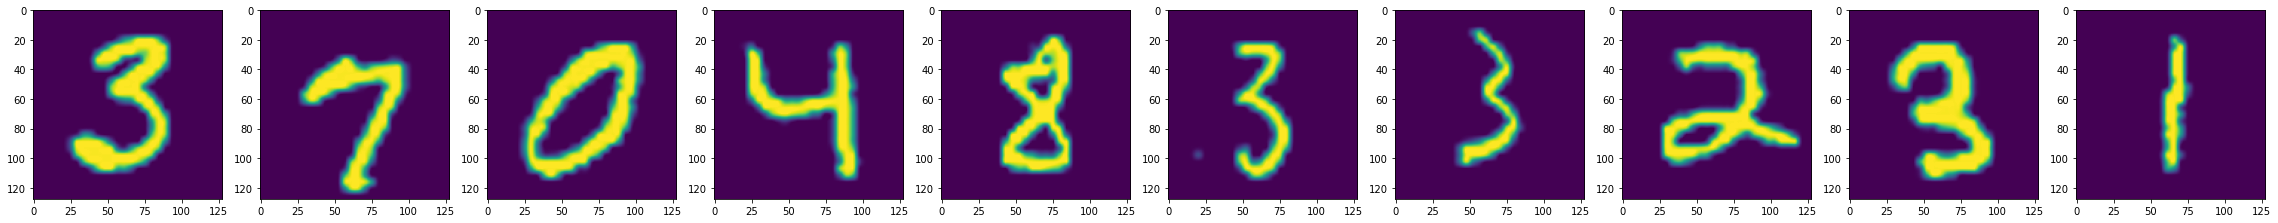

In [33]:
'''
Loading Multiple Samples
'''

# MNIST Dataset

plt.figure(figsize=(40,20))

for i in range(10):
    image = random.choice(mnist_test)
    ax=plt.subplot(1,10,i+1)
    plt.imshow(image)

## Model Training

#### Using Random Init Model

In [34]:
X = np.array(data, np.float32).reshape(60000,128,128,1)
Y = tf.keras.utils.to_categorical(target_val, 10)

In [35]:
X_tr, X_val, Y_tr, Y_val = train_test_split(X, Y, shuffle = True, random_state = 1)

In [43]:
'''
Defining Same Model. The model is kept same for comparision.
For each layer, the layer in initialised with random weights in normal distribution manner.
'''

model2 = keras.models.Sequential()

model2.add(keras.layers.Conv2D(filters=12, kernel_size=(5,5), strides=2, activation='relu', 
                              input_shape=(128,128,1), kernel_initializer='random_normal'))
# model.add(keras.layers.Dropout(.5))

model2.add(keras.layers.Conv2D(filters=18, kernel_size=(3,3) , strides=2, activation='relu', kernel_initializer='random_normal'))
model2.add(keras.layers.Dropout(.5))

model2.add(keras.layers.Conv2D(filters=24, kernel_size=(2,2), activation='relu', kernel_initializer='random_normal'))

model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(units=150, activation='relu',kernel_initializer='random_normal'))
model2.add(keras.layers.Dense(units=10, activation='softmax', kernel_initializer='random_normal'))

model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 62, 62, 12)        312       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 18)        1962      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 18)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 29, 29, 24)        1752      
_________________________________________________________________
flatten_4 (Flatten)          (None, 20184)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 150)               3027750   
_________________________________________________________________
dense_9 (Dense)              (None, 10)               

In [44]:
'''
Adding Callback API's to save best weights and change learning rate on the fly
Will be saved as task2_pretrained
'''
 
MCP = ModelCheckpoint('models/task3_random.h5', verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')
ES = EarlyStopping(monitor='val_accuracy', min_delta=0, verbose=0, restore_best_weights = True, patience=3, mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=0.0001)

In [45]:
%%time

'''
Training while also calculating time. 
THIS IS THE RANDOMLY INIT MODEL STEP ON TASK 3 DATA
'''

tf.config.run_functions_eagerly(True)

history = model2.fit(X_tr, Y_tr, validation_data = (X_val, Y_val), epochs=3, callbacks=[MCP,ES,RLP]) 

Epoch 1/3
1407/1407 [==============================] - 147s 104ms/step - loss: 2.3029 - accuracy: 0.0986 - val_loss: 2.3030 - val_accuracy: 0.0986

Epoch 00001: val_accuracy improved from -inf to 0.09860, saving model to models\task3_random.h5
Epoch 2/3
1407/1407 [==============================] - 140s 100ms/step - loss: 2.3023 - accuracy: 0.1029 - val_loss: 2.3029 - val_accuracy: 0.0997

Epoch 00002: val_accuracy improved from 0.09860 to 0.09967, saving model to models\task3_random.h5
Epoch 3/3
1407/1407 [==============================] - 145s 103ms/step - loss: 2.3025 - accuracy: 0.0994 - val_loss: 2.3032 - val_accuracy: 0.0997

Epoch 00003: val_accuracy did not improve from 0.09967
Wall time: 7min 12s


#### Using Pretrained Model

In [39]:
'''
Defining Pretrained Model and loading it.
'''

model = keras.models.Sequential()

model.add(keras.layers.Conv2D(filters=12, kernel_size=(5,5), strides=2, activation='relu', 
                              input_shape=(128,128,1)))
# model.add(keras.layers.Dropout(.5))

model.add(keras.layers.Conv2D(filters=18, kernel_size=(3,3) , strides=2, activation='relu'))
model.add(keras.layers.Dropout(.5))

model.add(keras.layers.Conv2D(filters=24, kernel_size=(2,2), activation='relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=150, activation='relu'))
model.add(keras.layers.Dense(units=10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 62, 62, 12)        312       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 18)        1962      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 30, 18)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 24)        1752      
_________________________________________________________________
flatten_3 (Flatten)          (None, 20184)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 150)               3027750   
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

In [40]:
'''
Loading Pretrained Model
'''

model = keras.models.load_model('models/task2_pretrained.h5')

In [41]:
'''
Adding Callback API's to save best weights and change learning rate on the fly
Will be saved as task2_pretrained
'''
 
MCP = ModelCheckpoint('models/task_3_model.h5', verbose=1, save_best_only=True, monitor='accuracy', mode='max')
ES = EarlyStopping(monitor='accuracy', min_delta=0, verbose=0, restore_best_weights = True, patience=3, mode='max')
RLP = ReduceLROnPlateau(monitor='loss', patience=3, factor=0.2, min_lr=0.0001)

In [42]:
%%time

'''
Training while also calculating time. 
THIS IS THE RETRAINING STEP ON TASK 3 DATA USING TASK 1 PRETRAINED MODEL
'''

tf.config.run_functions_eagerly(True)

history = model.fit(X, Y, epochs=5, callbacks=[MCP,ES,RLP]) 

Epoch 1/5
1875/1875 [==============================] - 207s 99ms/step - loss: 2.2878 - accuracy: 0.1086

Epoch 00001: accuracy improved from -inf to 0.10865, saving model to models\task_3_model.h5
Epoch 2/5
1875/1875 [==============================] - 195s 104ms/step - loss: 2.2582 - accuracy: 0.1164

Epoch 00002: accuracy improved from 0.10865 to 0.11637, saving model to models\task_3_model.h5
Epoch 3/5
1875/1875 [==============================] - 216s 115ms/step - loss: 2.2361 - accuracy: 0.1250

Epoch 00003: accuracy improved from 0.11637 to 0.12502, saving model to models\task_3_model.h5
Epoch 4/5
1875/1875 [==============================] - 182s 97ms/step - loss: 2.2179 - accuracy: 0.1356

Epoch 00004: accuracy improved from 0.12502 to 0.13565, saving model to models\task_3_model.h5
Epoch 5/5
1875/1875 [==============================] - 184s 98ms/step - loss: 2.1946 - accuracy: 0.1518

Epoch 00005: accuracy improved from 0.13565 to 0.15177, saving model to models\task_3_model.h5
W

## **Testing Both Models on MNIST Test Split**

In [48]:
'''
Setting Up MNIST Testing Data
'''

X_mnist_test = np.array(mnist_test, np.float32).reshape(10000,128,128,1)
Y_mnist_test = tf.keras.utils.to_categorical(mnist_test_labels, 10)

#### Testing Model 1 (Random Model)

In [54]:
Random_preds = model2.predict(X_mnist_test)
print(model2.evaluate(X_mnist_test, Y_mnist_test))

C:\Users\infin\miniconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


313/313 [==============================] - 9s 28ms/step - loss: 2.3040 - accuracy: 0.0892
[2.3039515018463135, 0.08919999748468399]


In [52]:
'''
Calculating Metrics for Model 1 (Random)
'''

cm = confusion_matrix(np.argmax(Y_mnist_test, axis = 1), np.argmax(Random_preds, axis = 1))
print(classification_report(np.argmax(Y_mnist_test, axis = 1), np.argmax(Random_preds, axis = 1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.09      1.00      0.16       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.09     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.09      0.01     10000



C:\Users\infin\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\infin\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\infin\miniconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Testing Model *2*

In [51]:
Pretrained = model.predict(X_mnist_test)
print(model.evaluate(X_mnist_test, Y_mnist_test))

C:\Users\infin\miniconda3\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


313/313 [==============================] - 9s 28ms/step - loss: 4.5684 - accuracy: 0.0021
[4.568363666534424, 0.002099999925121665]


In [53]:
'''
Calculating Metrics for Model 2 (Pretrained)
'''

cm = confusion_matrix(np.argmax(Y_mnist_test, axis = 1), np.argmax(Pretrained, axis = 1))
print(classification_report(np.argmax(Y_mnist_test, axis = 1), np.argmax(Pretrained, axis = 1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.01      0.00      0.00      1009

    accuracy                           0.00     10000
   macro avg       0.00      0.00      0.00     10000
weighted avg       0.00      0.00      0.00     10000

